In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git pull

!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 15637, done.
remote: Counting objects: 100% (244/244), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 15637 (delta 123), reused 173 (delta 101), pack-reused 15393
Receiving objects: 100% (15637/15637), 14.65 MiB | 6.95 MiB/s, done.
Resolving deltas: 100% (10647/10647), done.
/content/yolov5
Already up to date.
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.13.0 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
!curl -L "https://app.roboflow.com/ds/YCsKLvAbzh?key=wauxyPlLFl" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2256      0 --:--:-- --:--:-- --:--:--  2258
100 67.7M  100 67.7M    0     0  44.6M      0  0:00:01  0:00:01 --:--:-- 73.9M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: train/
   creating: train/images/
 extracting: train/images/train_BLA_0001_JPG.rf.6dfdc831a8d4eeccb161f8ec4135cb5c.jpg  
 extracting: train/images/train_BLA_0003_JPG.rf.c69e21b8092edf615d65223dce972852.jpg  
 extracting: train/images/train_BLA_0004_JPG.rf.50b023488b13e33cb0ad8a592ae8631d.jpg  
 extracting: train/images/train_BLA_0005_JPG.rf.eba3b36853391b05129bca52bf72e864.jpg  
 extracting: train/images/train_BLA_0007_JPG.rf.0593c71b90ae833c61c91eecf2a5cdca.jpg  
 extracting: train/images/train_BLA_0008_JPG.rf.a3adf62e4d2bc6979376b184f4231f95.jpg  
 extracting: tra

In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['human']

In [ ]:
# define number of classes based on YAML
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat ./data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['human']

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate ./data.yaml

# parameters
train : ./train
val : ./valid
names : ['Person']
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat ./models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
!pip install wandb -q

In [ ]:
cd yolov5

[Errno 2] No such file or directory: 'yolov5'
/kaggle/working/yolov5


In [ ]:
ls

Dockerfile           data/       models/            train.py        weights/
LICENSE              data.yaml   requirements.txt*  tutorial.ipynb
README.md*           detect.py   test.py            utils/
README.roboflow.txt  hubconf.py  train/             valid/


In [ ]:
!git pull

Updating 886f1c0..8ecc727
Fast-forward
 .dockerignore                                      |   14 +-
 .github/ISSUE_TEMPLATE/bug-report.md               |   55 -
 .github/ISSUE_TEMPLATE/bug-report.yml              |   85 ++
 .github/ISSUE_TEMPLATE/config.yml                  |   11 +
 .github/ISSUE_TEMPLATE/feature-request.md          |   27 -
 .github/ISSUE_TEMPLATE/feature-request.yml         |   50 +
 .github/ISSUE_TEMPLATE/question.md                 |   13 -
 .github/ISSUE_TEMPLATE/question.yml                |   33 +
 .github/PULL_REQUEST_TEMPLATE.md                   |   13 +
 .github/dependabot.yml                             |   31 +-
 .github/workflows/ci-testing.yml                   |  201 ++-
 .github/workflows/codeql-analysis.yml              |   66 +-
 .github/workflows/docker.yml                       |   57 +
 .github/workflows/greetings.yml                    |   73 +-
 .github/workflows/links.yml                        |   38 +
 .github/workflows/rebase.yml          

In [ ]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda:0")
else:
    print("GPU not available, using CPU instead")
    device = torch.device("cpu")


GPU is available


In [ ]:
!export WANDB_API_KEY=742aac2df6aee3508d1fdb5ad95cb60e7ea2dbdd && python train.py --img 416 --batch 16 --epochs 100 --data './data.yaml' --cfg ./models/yolov5s.yaml --weights '' --name ./yolov5s_results --cache

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: maxim652002 (itmo_). Use `wandb login --relogin` to force relogin
train: weights=, cfg=./models/yolov5s.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=./yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /kaggle/working/requirements.txt not found, check fa

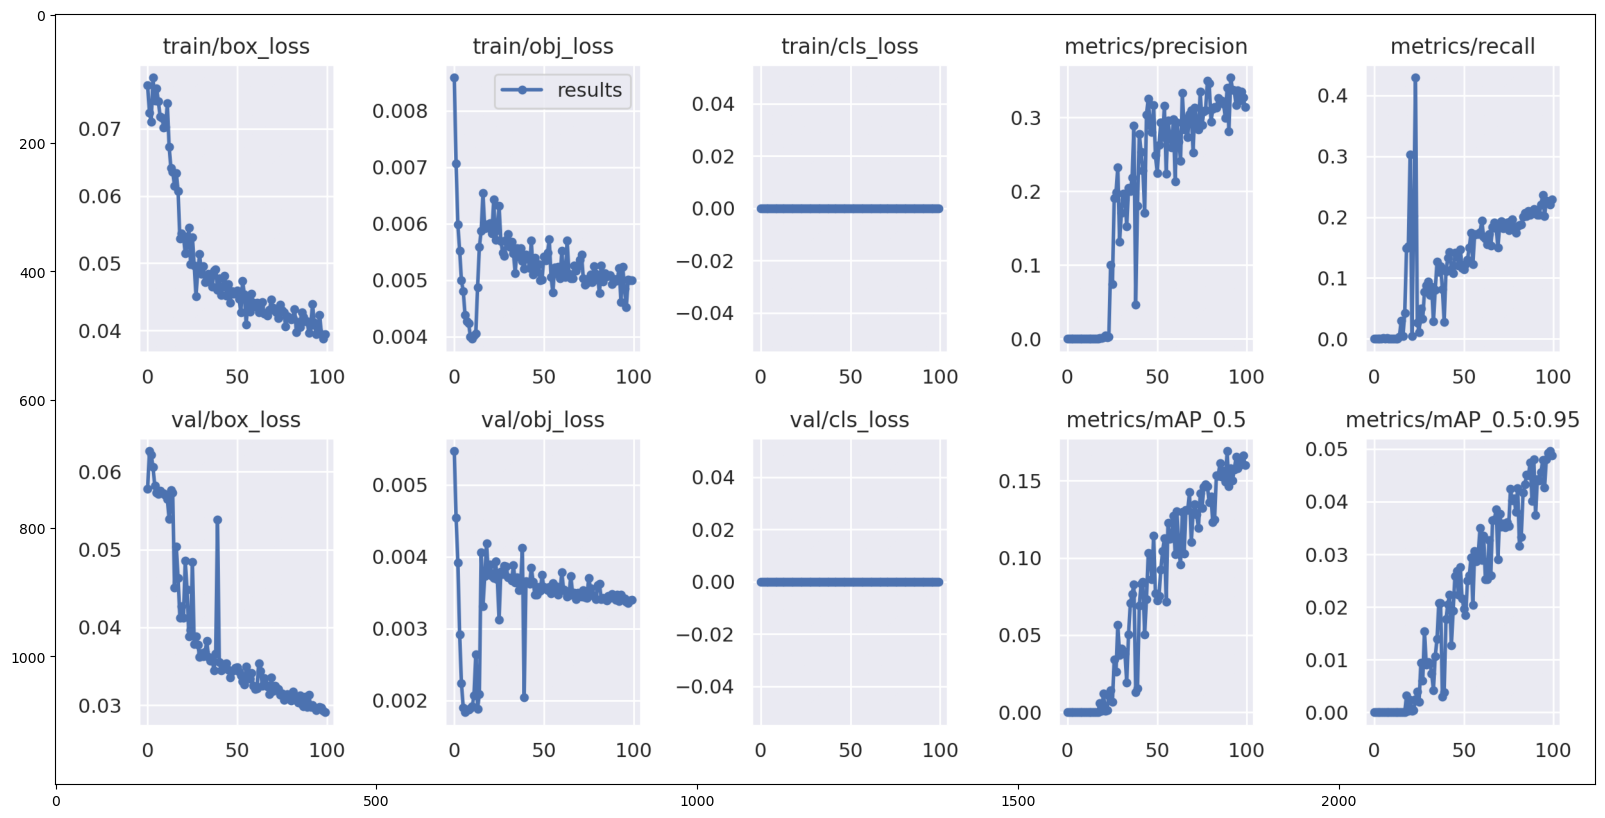

In [ ]:
img = mpimg.imread('./runs/train/yolov5s_results2/results.png')

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.show()

In [ ]:
!python detect.py --weights ./runs/train/yolov5s_results2/weights/best.pt --img 416 --conf 0.4 --source ./valid/images

detect: weights=['./runs/train/yolov5s_results2/weights/best.pt'], source=./valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /kaggle/working/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/377 /kaggle/working/yolov5/valid/images/train_BLA_0002_JPG.rf.0853fda95c799c8d505bdcf8bb5937d4.jpg: 416x416 1 Person, 11.0ms
image 2/377 /kaggle/working/yolov5/valid/images/train_BLA_0006_JPG.rf.586dd34289f6bc89c3fd33b16c30190e.jpg: 416x416 2 Persons, 12.4ms
im

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

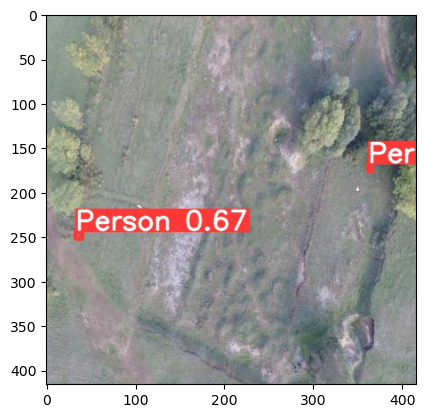

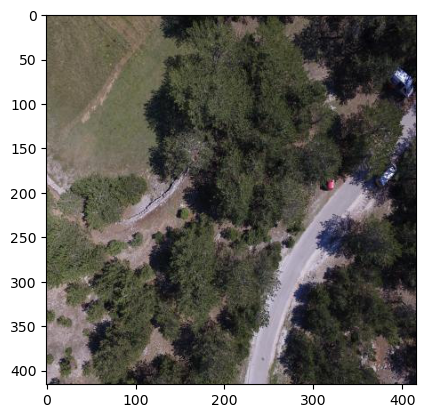

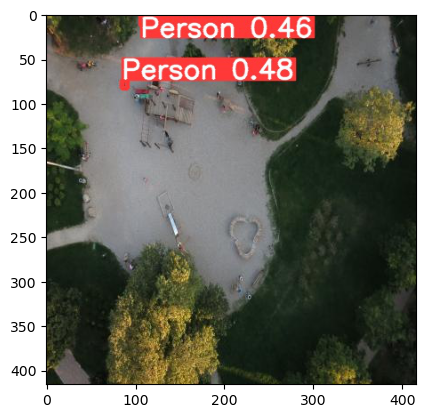

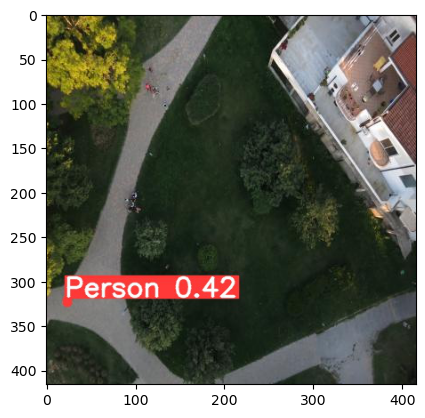

In [ ]:
for det_img in [
    'train_BLA_0006_JPG.rf.586dd34289f6bc89c3fd33b16c30190e.jpg',
    'train_BRA_1003_JPG.rf.a3f32a60314fdb79d054f284d712f1c8.jpg',
    'train_ZRI_2012_JPG.rf.c9d7bfac5fbc26c34c2e567ee09ed736.jpg',
    'train_ZRI_2018_JPG.rf.20a15d8fc0c97f8f4add326d3890030c.jpg']:
    # Загрузка изображения
    img = mpimg.imread('/kaggle/working/yolov5/runs/detect/exp6/'+det_img)

    # Отображение изображения
    plt.imshow(img)
    plt.show()

In [ ]:
!python val.py --weights ./runs/train/yolov5s_results2/weights/best.pt --data ./data.yaml --img 416 --half

val: data=./data.yaml, weights=['./runs/train/yolov5s_results2/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
requirements: /kaggle/working/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-155-g8ecc727 Python-3.7.12 torch-1.13.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/working/yolov5/valid/labels.cache... 377 images, 149 backg
                 Class     Images  Instances          P          R      mAP50   
                   all        377        638       0.33      0.221      0.166     0.0496
Speed: 0.2ms pre-process, 2.3ms inference, 1.9ms NMS per image at shape (32, 3, 416, 416)
Results saved to runs/val/exp


In [ ]:
!ls /runs/val/exp

F1_curve.png  confusion_matrix.png   val_batch1_pred.jpg
PR_curve.png  val_batch0_labels.jpg  val_batch2_labels.jpg
P_curve.png   val_batch0_pred.jpg    val_batch2_pred.jpg
R_curve.png   val_batch1_labels.jpg


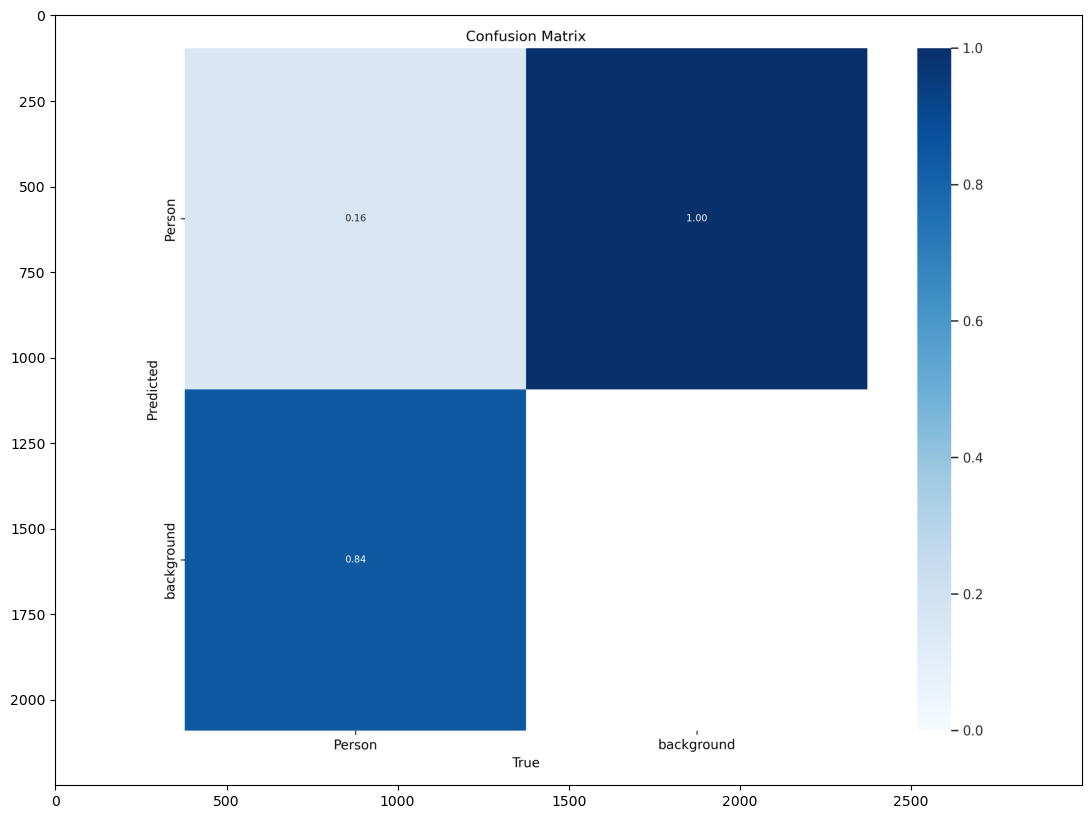

In [ ]:
img = mpimg.imread('./runs/val/exp/confusion_matrix.png')

plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.show()

#### FPS
FPS означает «Кадров в секунду». Это метрика, обычно используемая для оценки производительности приложений компьютерного зрения в реальном времени, таких как обнаружение объектов, отслеживание и обработка видео. В контексте моделей обнаружения объектов и глубокого обучения, таких как YOLO, FPS используется для измерения того, насколько быстро модель может обрабатывать изображения на этапе вывода или прогнозирования, а не на этапе обучения.

Более высокий FPS указывает на то, что модель может обрабатывать больше изображений за заданный промежуток времени, что делает ее более подходящей для приложений реального времени, где требуется быстрое и точное обнаружение. Более низкие значения FPS могут быть не идеальными для сценариев реального времени, но все же могут использоваться в менее чувствительных ко времени приложениях.

Посчитаем его основываясь на параметрах детекции:

    - Pre-process time: 0.3ms
    - Inference time: 11.2ms
    - NMS (Non-Maximum Suppression) time: 0.3ms
    
Чтобы рассчитать FPS, нужно сложить эти времена вместе, чтобы получить общее время на изображение, а затем преобразовать его в кадры в секунду.

Общее время на изображение (в секундах) = (0,3 + 11,2 + 0,3) / 1000 = 0,0118 секунд

Теперь посчитаем FPS:

FPS = 1 / Общее время на изображение = 1 / 0,0118 = 84,75

Итак, FPS для вашей модели составляет 84,75.

## Итог
Мы использовали модель Yolo V5 small
Это настраиваемый файл конфигурации модели YOLOv5. Модель имеет конструкцию, состоящую из позвоночника и головы. Магистраль отвечает за извлечение признаков, а головка отвечает за обнаружение объектов с помощью блоков привязки. Вот разбивка структуры:

 train и val указывают пути набора данных для обучения и проверки соответственно.
 имена содержат имена классов в вашем наборе данных (в данном случае «Человек»).
 nc — количество классов.
 depth_multiple и width_multiple — это гиперпараметры, управляющие глубиной и шириной модели.
 привязки — это предопределенные размеры блока привязки для различных масштабов карты объектов (P3/8, P4/16, P5/32).

Костяк состоит из:

Focus layer: объединяет пространственную информацию от соседних пикселей во входном изображении.
Conv layers: выполните свертки с шагом 2, чтобы уменьшить выборку карт объектов.
BottleneckCSP layers: межэтапные иерархические сети для лучшего градиентного потока и повторного использования функций.
SPP (Spatial Pyramid Pooling) layer: объединяет объекты в нескольких масштабах для лучшего обнаружения объектов в разных масштабах.

head состоит из:

 Слои Conv: уменьшите размер канала карт объектов.
 Повышение дискретизации слоев: повышайте дискретизацию карт объектов для объединения с объектами более низкого уровня.
 Слои Concat: объединяйте карты объектов из основы и головы.
 Слои узких мест CSP: Уточните объединенные карты объектов.
 Слой обнаружения: выполните обнаружение объектов с помощью полей привязки и выведите окончательные прогнозы.

Модель использует три разных масштаба карты признаков (P3/8, P4/16, P5/32) для обнаружения объектов, что помогает обнаруживать объекты разных размеров на входных изображениях.

## метрики
- P    0.33          
- R    0.221    
- mAP50 0.166 
- mAP50-95: 0.049
- FPS 84,75

In [ ]:
import shutil

shutil.move('source_path/filename.extension', '/kaggle/working/filename.extension')


In [ ]:
!tar -czf output.tar.gz /kaggle/working/*
